# E6. House Price Prediction(부동산 가격 예측)

## 1. 프로젝트 개요
- 집의 가격은 주거 공간의 면적, 위치, 경관, 건물의 연식 등 여러 가지 복잡한 요인의 조합에 의해 결정됨
- 집값 예측을 하는데에 있어 20개의 변수를 바탕으로, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델 만들기

## 2. 데이터셋 소개
### File Description:
- train.csv: 예측 모델을 만들기 위해 사용하는 학습 데이터. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있음
- test.csv: 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터
- sample_submission: 제출시 사용할 수 있는 예시 submission.csv 파일

### Data fields
- 1. ID: 집을 구분하는 번호
- 2. date: 집을 구매한 날짜
- 3. price: 집의 가격(Target variable)
- 4. bedrooms: 침실의 수
- 5. bathrooms: 침실당 화장실 개수
- 6. sqft_living: 주거 공간의 평방 피트(면적)
- 7. sqft_lot: 부지의 평방 피트(면적)
- 8. floors: 집의 층 수
- 9. waterfront: 집의 전방에 강이 흐르는지 유무(a.k.a 리버뷰)
- 10. view: 집이 얼마나 좋아 보이는지의 정도
- 11. condition: 집의 전반적인 상태
- 12. grade: King Country grading 시스템 기준으로 매긴 집의 등급
- 13. sqft_above: 지하실을 제외한 평방 피트(면적)
- 14. sqft_basement: 지하실의 평방 피트(면적)
- 15. yr_built: 집을 지은 년도
- 16. yr_renovated: 집을 재건축한 년도
- 17. zipcode: 우편번호
- 18. lat: 위도
- 19. long: 경도
- 20. sqft_living15: 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- 21. sqft_lot15: 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 3. Baseline 만들어보기

In [1]:
# 시각화에 필요한 라이브러리 import
import matplotlib.pyplot as plt
%matplotlib inline
# 그래프를 더 높은 해상도로 출력
%config InlineBackend.figure_Format = 'retina'

In [2]:
# 필요한 라이브러리 import하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.shape, test.shape

((15035, 21), (6468, 20))

In [4]:
# 데이터 살펴보기
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# 'date' 전처리 -> int 정수형 데이터로 처리
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
# 타겟 데이터에 해당하는 'price' 컬럼
# y 변수에 'price' 넣어두고, train에서는 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# id 컬럼 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# test 데이터에 대해서도 같은 작업 진행
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

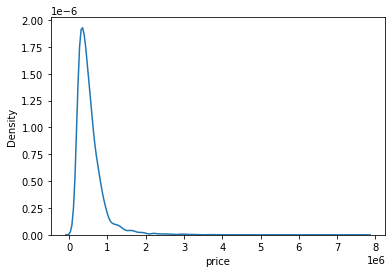

In [10]:
# 가격 데이터의 분포 확인
sns.kdeplot(y)
plt.show()

In [11]:
# np.log1p() 함수를 통해 로그 변환
# 나중에 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌리기
# np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x) - 1의 값 반환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

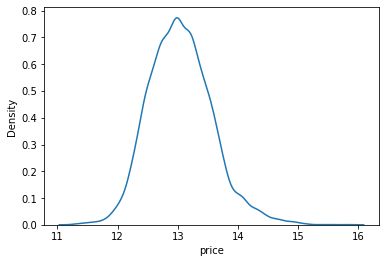

In [12]:
sns.kdeplot(y)
plt.show()

In [13]:
# 전체 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [14]:
# RMSE 계산하기 위한 함수
# y_test, y_pred는 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 함
# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt 취하면 RMSE 값 얻을 수 있음
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

- 아래와 같이 모델 인스턴스를 생성한 후, 'models'라는 리스트에 넣어주기
- 이때, 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜던 시드값인'random_state' 값을 특정 값으로 고정시키거나, 아니면 지정하지 않고 None으로 세팅
- random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우, 머신러닝 학습결과도 항상 동일하게 재현
- 하지만, 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택
- 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라짐
- 앞으로, 베이스라인에서부터 시작해서 다양한 실험 통해 성능이 개선되는지를 검증해 보려고 함
- 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 함
- 따라서, 아래와 같이 random_state 값을 특정 값으로 고정
- 혹시 고정하지 않았을 때 어떤 상황이 벌어지는지 궁금하다면 random_state 값을 None으로 남겨두고 실험 반복

In [15]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값
# random_state = None가 초기값. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택
# 고정값을 2020으로 세팅
random_state = 2020

gboost = GradientBoostingRegressor(random_state = random_state)
xgboost = XGBRegressor(random_state = random_state)
lightgbm = LGBMRegressor(random_state = random_state)
rdforest = RandomForestRegressor(random_state = random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [16]:
# 위의 과정을 'get_scores(models, train, y)' 함수로 만들어 보기
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, raondom_state = random_state, test_size = 0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = False)
    
    return score_df

## 4. 하이퍼파라미터 튜닝

- 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합 찾아보기
- 캐글에서의 성적 또는 모델의 성능을 최대화하기 위한 방법에는 하이퍼 파라미터 튜닝만 있는 것은 절대 아님
- 앞선 과정에서 배웠거나 앞으로 배울 내용에서도 다루듯 모델의 성능을 최적화하는 방법은 매우 많고, 지금도 끊임없이 연구되고 있음
- 예를 들어, 가장 기본적으로는 데이터를 깊게 탐색하는 **EDA** 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요
- 데이터가 무엇이냐에 따라, 그리고 그 데이터를 어떻게 정제하느냐에 따라 모델의 파라미터를 튜닝하는 것만으로는 절대 얻을 수 없는 성능 향상이 이루어질 수 있음
- 하이퍼 파라미터 튜닝은 최적화 방법 중 하나일 뿐

## 시도해볼 수 있는 방법

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기(피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 3가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기
- 이외에도 자유롭게 여러 가지 방법을 활용해서 점수 끌어올려보기
- [캐글 커널](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks): 진행하면서 도움이 될 수 있는 가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널
    - 아주 다양하게 데이터를 탐색해 본 커널도 있고, 상윙궈을 달성한 커널은 이번 노드에서 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 함
- 여러 가지 실험을 해보고 결과 csv는 캐글에, 사용한 노트북은 깃허브(GitHub)를 통해 LMS에 제출
- 제출한 노트북에는 캐글 Submission 스코어 기재

### 튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같음
- max_depth: 의사 결정 나무의 깊이, 정수 사용
- learning_rate: 한 스텝에 이동하는 양을 결정하는 파라미터. 보통 0.00001 ~ 0.1 사이의 실수 사용
- n_estimators: 사용하는 개별 모델의 개수. 보통 50 ~ 100 이상의 정수 사용
- num_leaves: 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type: 부스팅 방식, gbdt, rf 등의 문자열 입력
- 위에서는 n_estimators, max_depth에 대해서만 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합 찾아볼 수 있음
- 실제로 lightgbm에 넣을 수 있는 인자는 아래 자료들에서 설명하는 것처럼 매우 다양함
- [lightGBM/XGBoost 파라미터 설명](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)
- [Chapter 4. 분류 - LightGBM](https://injo.tistory.com/48)
- 위의 자료 외에도, 'lightgbm, xgboost 하이퍼 파라미터 튜닝' 키워드로 검색해보면 다양한 하이퍼 파라미터의 종류 확인할 수 있음
- 실험 과정에서는 위에서 만들었던 'my_GridSearch(), save_submission() 등의 함수 사용해도 되고, 혹은 새로운 함수 만들어서 사용해도 됨

In [17]:
# 'param_gird'에 탐색할 xgboost 관련 하이퍼 파라미터 넣어서 준비
param_grid = {
    'n_estimators':[25, 50, 75, 100, 125, 150],
    'max_depth':[1, 5, 10, 15, 20],
}

In [18]:
model = LGBMRegressor(random_state=random_state)

In [19]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:   10.6s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'n_estimators': [25, 50, 75, 100, 125, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
grid_model.cv_results_

{'mean_fit_time': array([0.0779336 , 0.0936964 , 0.11463361, 0.12156425, 0.15088034,
        0.15532598, 0.1258718 , 0.19040017, 0.23788118, 0.29559889,
        0.3373693 , 0.38114591, 0.1559269 , 0.23564506, 0.3156435 ,
        0.3846911 , 0.44566169, 0.51762061, 0.16363592, 0.24378734,
        0.32720957, 0.38423252, 0.46462607, 0.52681184, 0.1604887 ,
        0.25273237, 0.32225189, 0.39373026, 0.46724882, 0.52239881]),
 'std_fit_time': array([0.00779759, 0.00347616, 0.00902128, 0.00407545, 0.00834968,
        0.00682573, 0.00482111, 0.00155019, 0.01428658, 0.00924229,
        0.01345116, 0.0117632 , 0.01204236, 0.01715628, 0.01995673,
        0.01717016, 0.01484475, 0.0181422 , 0.01270947, 0.01543146,
        0.01434733, 0.01342895, 0.01930913, 0.02594803, 0.01416277,
        0.01522326, 0.00796494, 0.02832511, 0.02566877, 0.02612628]),
 'mean_score_time': array([0.0085803 , 0.00529175, 0.00664544, 0.01295509, 0.00946622,
        0.02327046, 0.00720601, 0.01198487, 0.02526226, 0.02

In [21]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 25},
 {'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 75},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 125},
 {'max_depth': 1, 'n_estimators': 150},
 {'max_depth': 5, 'n_estimators': 25},
 {'max_depth': 5, 'n_estimators': 50},
 {'max_depth': 5, 'n_estimators': 75},
 {'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 5, 'n_estimators': 125},
 {'max_depth': 5, 'n_estimators': 150},
 {'max_depth': 10, 'n_estimators': 25},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 75},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 125},
 {'max_depth': 10, 'n_estimators': 150},
 {'max_depth': 15, 'n_estimators': 25},
 {'max_depth': 15, 'n_estimators': 50},
 {'max_depth': 15, 'n_estimators': 75},
 {'max_depth': 15, 'n_estimators': 100},
 {'max_depth': 15, 'n_estimators': 125},
 {'max_depth': 15, 'n_estimators': 150},
 {'max_depth': 20, 'n_estimators': 25},


In [22]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.10302959, -0.07339447, -0.06149896, -0.05502043, -0.05113975,
       -0.04842797, -0.03964623, -0.03178273, -0.02971396, -0.02879666,
       -0.02817393, -0.02770773, -0.03704046, -0.02917734, -0.02766514,
       -0.02702714, -0.0266837 , -0.02645818, -0.03704359, -0.02916999,
       -0.02771366, -0.02717401, -0.02677797, -0.02660465, -0.03704359,
       -0.02919842, -0.02764603, -0.02705114, -0.02666527, -0.02646027])

In [23]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,25,-0.103030
1,1,50,-0.073394
2,1,75,-0.061499
3,1,100,-0.055020
4,1,125,-0.051140
5,1,150,-0.048428
6,5,25,-0.039646
7,5,50,-0.031783
8,5,75,-0.029714
9,5,100,-0.028797


In [24]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,25,-0.103030,0.320982
1,1,50,-0.073394,0.270914
2,1,75,-0.061499,0.247990
3,1,100,-0.055020,0.234564
4,1,125,-0.051140,0.226141
5,1,150,-0.048428,0.220064
6,5,25,-0.039646,0.199114
7,5,50,-0.031783,0.178277
8,5,75,-0.029714,0.172377
9,5,100,-0.028797,0.169696


In [25]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,25,-0.103030,0.320982
1,1,50,-0.073394,0.270914
2,1,75,-0.061499,0.247990
3,1,100,-0.055020,0.234564
4,1,125,-0.051140,0.226141
5,1,150,-0.048428,0.220064
6,5,25,-0.039646,0.199114
7,5,50,-0.031783,0.178277
8,5,75,-0.029714,0.172377
9,5,100,-0.028797,0.169696


### GridSearch

In [26]:
"""
다음과 같은 과정을 진행할 수 있는 'my_GridSearch(model, train, y , param_grid, verbose = 2, n_jobs = 5)' 함수를 구현

1. GridSearchCV 모델로 'model'을 초기화
2. 모델을 fitting하기
3. params, score에 각 조합에 대한 결과를 저장
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 'results' 반환
"""
def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # 1. GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 2. 모델 fitting
    grid_model.fit(train, y)
    
    # 3. 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 4. 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # 5. RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

- 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합 찾아보기
- 캐글에서의 성적 또는 모델의 성능을 최대화하기 위한 방법에는 하이퍼 파라미터 튜닝만 있는 것은 절대 아님
- 앞선 과정에서 배웠거나 앞으로 배울 내용에서도 다루듯 모델의 성능을 최적화하는 방법은 매우 많고, 지금도 끊임없이 연구되고 있음
- 예를 들어, 가장 기본적으로는 데이터를 깊게 탐색하는 **EDA** 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요
- 데이터가 무엇이냐에 따라, 그리고 그 데이터를 어떻게 정제하느냐에 따라 모델의 파라미터를 튜닝하는 것만으로는 절대 얻을 수 없는 성능 향상이 이루어질 수 있음
- 하이퍼 파라미터 튜닝은 최적화 방법 중 하나일 뿐

### 스태킹 앙상블 모델을 통한 회귀 예측
- 스태킹 모델의 구현 방법: 2종류의 모델 필요
    - 1. 개별적인 기반 모델
    - 2. 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것
- 최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것
- 개별 모델을 스태킹 모델로 제공하기 위해 데이터 세트를 생성하기 위한 get_stacking_base_datasets() 함수

In [28]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 15, 20],
}

model = LGBMRegressor(random_state = random_state)
my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    4.4s finished


,max_depth,n_estimators,score,RMSLE
5,10,150,-0.026458,0.162660
11,20,150,-0.026460,0.162666
8,15,150,-0.026605,0.163109
4,10,100,-0.027027,0.164399
10,20,100,-0.027051,0.164472
7,15,100,-0.027174,0.164845
6,15,50,-0.029170,0.170792
3,10,50,-0.029177,0.170814
9,20,50,-0.029198,0.170875
2,1,150,-0.048428,0.220064


In [29]:
# 가장 좋은 조합은 max_depth = 10, n_estimators = 100
# 해당 모델로 학습을 해서 예측값인 submission.csv 파일 만들어서 제출
# 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과 생성
model = LGBMRegressor(max_depth = 10, n_estimators = 100, random_state = random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [30]:
# 예측 결과에 np.expm1() 씌워서 다시 원래 스케일로 되돌리기
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [31]:
# sample_submission.csv 파일 가져오기
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [32]:
# 위의 데이터프레임에 우리의 모델이 예측한 값 덮어씌우기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [33]:
# 위의 데이터를 csv 파일로 저장
# 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주기
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index = False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [34]:
# save_submission함수로 정리
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수 구현하기
1. 모델을 `train`, `y`로 학습시킴
2. `test`에 대해 예측
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장
"""
# 1. 모델을 'train', 'y'로 학습시킴
def save_submission(model, train, y, test, model_name, rmsle = None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index = False)
    print('{} saved!'.format(submission_csv_path))

In [35]:
save_submission(model, train, y, test, 'lgbm', rmsle = '0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


## 프로젝트 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

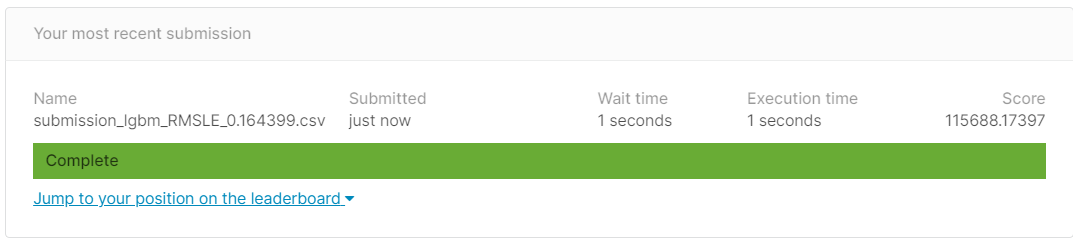